In [31]:
import tensorflow as tf

In [32]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [33]:
import librosa
import librosa.display
import librosa.feature

In [34]:
import requests
import os
from tqdm import tqdm

fn = "SopSax.Vib.pp.C6Eb6.aiff"
url = "http://theremin.music.uiowa.edu/sound files/MIS/Woodwinds/sopranosaxophone/"+fn

# TODO 1:  Load the file from url and save it in a file under the name fn
def download_file(src_url, dst_fn):
    
    if os.path.exists(dst_fn):
        print('File %s already exists' % dst_fn)
        return
    
    print('Downloading %s' % dst_fn)
    
    # Streaming, so we can iterate over the response.
    r = requests.get(src_url, stream=True)

    # Total size in MB.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    wrote = 0 
    with open(dst_fn, 'wb') as f:
        with tqdm(total=total_size//block_size, unit='kB', 
                           unit_scale=True, unit_divisor=1024) as pbar:
            for data in r.iter_content(block_size):
                wrote = wrote + len(data)
                pbar.update(1)
                f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong") 

if os.path.exists(fn):
    print('Files already downloaded')
    files_exists = True
else:
    files_exists = False
if not files_exists:
    # First download the zip file if needed
    download_file(url, fn)


Files already downloaded


In [35]:
# TODO 2
import librosa
y, sr = librosa.load("SopSax.Vib.pp.C6Eb6.aiff")

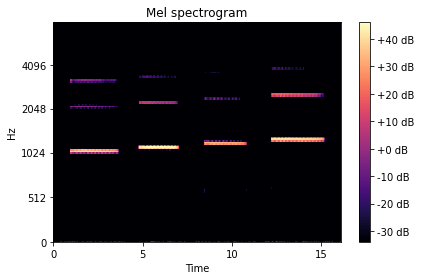

In [36]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
librosa.display.specshow(librosa.amplitude_to_db(S),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
data_dir = '/content/drive/MyDrive/ColabNotebooks/instrument_dataset/'

Xtr = np.load(data_dir+'uiowa_train_data.npy')
ytr = np.load(data_dir+'uiowa_train_labels.npy')
Xts = np.load(data_dir+'uiowa_test_data.npy')
yts = np.load(data_dir+'uiowa_test_labels.npy')

In [39]:
# TODO 3
ntr = Xtr.shape[0]
nts = Xts.shape[0]
ncol = Xtr.shape[1]
nclass = np.max(ytr)+1
print("Number of trainng sample = {}, number of testing sample = {}".format(ntr,nts))
print("Number of features = {}, Number of classes = {}".format(ncol,nclass))

Number of trainng sample = 66247, number of testing sample = 14904
Number of features = 120, Number of classes = 10


In [40]:
# TODO 4: Scale the training and test matrices
xm = np.mean(Xtr,axis=0)
xstd = np.std(Xtr,axis=0)
Xtr_scale = (Xtr-xm[None,:])/xstd[None,:] 
Xts_scale = (Xts-xm[None,:])/xstd[None,:]

In [41]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation
import tensorflow.keras.backend as K
# TODO 5 clear session
K.clear_session()

In [42]:
# TODO 6: construct the model
nin = ncol
nh = 256
nout = np.max(ytr)+1
model = Sequential()
model.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
model.add(Dense(units=nout, activation='softmax', name='output'))

In [43]:
# TODO 7:  Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden (Dense)              (None, 256)               30976     
                                                                 
 output (Dense)              (None, 10)                2570      
                                                                 
Total params: 33,546
Trainable params: 33,546
Non-trainable params: 0
_________________________________________________________________


In [44]:
# TODO 8
from tensorflow.keras import optimizers
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [45]:
# TODO 9
hist = model.fit(Xtr_scale, ytr, epochs=10, batch_size=100, validation_data=(Xts_scale,yts))

Epoch 1/10
663/663 [==============================] - 2s 3ms/step - loss: 0.3592 - accuracy: 0.9039 - val_loss: 0.1836 - val_accuracy: 0.9503
Epoch 2/10
663/663 [==============================] - 2s 3ms/step - loss: 0.1017 - accuracy: 0.9754 - val_loss: 0.1088 - val_accuracy: 0.9655
Epoch 3/10
663/663 [==============================] - 2s 3ms/step - loss: 0.0601 - accuracy: 0.9853 - val_loss: 0.0659 - val_accuracy: 0.9824
Epoch 4/10
663/663 [==============================] - 2s 3ms/step - loss: 0.0422 - accuracy: 0.9893 - val_loss: 0.0541 - val_accuracy: 0.9851
Epoch 5/10
663/663 [==============================] - 2s 3ms/step - loss: 0.0322 - accuracy: 0.9919 - val_loss: 0.0375 - val_accuracy: 0.9907
Epoch 6/10
663/663 [==============================] - 2s 3ms/step - loss: 0.0255 - accuracy: 0.9933 - val_loss: 0.0332 - val_accuracy: 0.9899
Epoch 7/10
663/663 [==============================] - 2s 3ms/step - loss: 0.0209 - accuracy: 0.9946 - val_loss: 0.0343 - val_accuracy: 0.9901
Epoch 

Text(0, 0.5, 'Validation Accuracy')

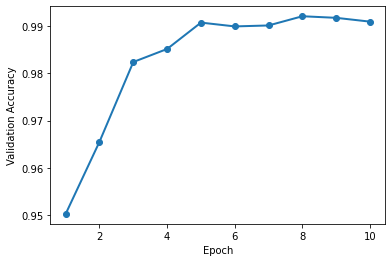

In [49]:
# TODO 10
xp = np.arange(1,11)
plt.plot(xp,hist.history['val_accuracy'],'o-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')

Text(0, 0.5, 'Loss')

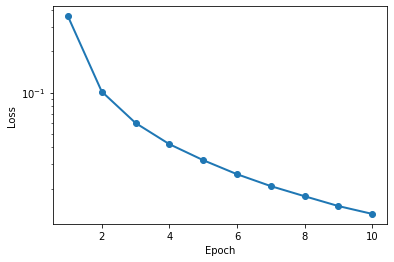

In [50]:
# TODO 11
plt.semilogy(xp,hist.history['loss'],'o-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [52]:
rates = [0.01,0.001,0.0001]
batch_size = 100
loss_hist = []
acc_hist = []

# TODO 12
for lr in rates:
  K.clear_session()
  model_ = Sequential()
  model_.add(Dense(units=nh, input_shape=(nin,), activation='sigmoid', name='hidden'))
  model_.add(Dense(units=nout, activation='softmax', name='output'))
  opt_ = optimizers.Adam(lr=lr)
  model_.compile(optimizer=opt_,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  hist = model_.fit(Xtr_scale, ytr, epochs=20, batch_size=batch_size, validation_data=(Xts_scale,yts))
  loss_hist.append(hist.history['loss'])
  acc_hist.append(hist.history['val_accuracy'])


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


663/663 [==============================] - 2s 3ms/step - loss: 0.1076 - accuracy: 0.9665 - val_loss: 0.0650 - val_accuracy: 0.9769
Epoch 2/20
663/663 [==============================] - 2s 3ms/step - loss: 0.0292 - accuracy: 0.9901 - val_loss: 0.0380 - val_accuracy: 0.9852
Epoch 3/20
663/663 [==============================] - 2s 3ms/step - loss: 0.0209 - accuracy: 0.9928 - val_loss: 0.0716 - val_accuracy: 0.9742
Epoch 4/20
663/663 [==============================] - 2s 3ms/step - loss: 0.0193 - accuracy: 0.9935 - val_loss: 0.1079 - val_accuracy: 0.9660
Epoch 5/20
663/663 [==============================] - 2s 3ms/step - loss: 0.0173 - accuracy: 0.9942 - val_loss: 0.0306 - val_accuracy: 0.9893
Epoch 6/20
663/663 [==============================] - 2s 3ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.0507 - val_accuracy: 0.9826
Epoch 7/20
663/663 [==============================] - 2s 3ms/step - loss: 0.0148 - accuracy: 0.9952 - val_loss: 0.0369 - val_accuracy: 0.9872
Epoch 8/20
663/66

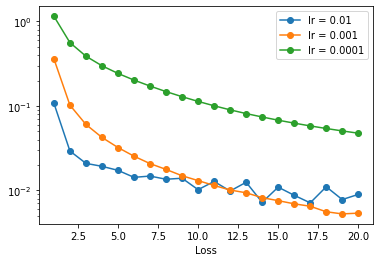

In [53]:
# TODO 13
xp = np.arange(1,21)
plt.semilogy(xp,loss_hist[0],'o-',label="lr = 0.01")
plt.semilogy(xp,loss_hist[1],'o-',label="lr = 0.001")
plt.semilogy(xp,loss_hist[2],'o-',label="lr = 0.0001")
plt.xlabel("Epoch")
plt.xlabel("Loss")
plt.legend()